In [97]:
import poppy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

In [98]:
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'

In [99]:
# No FPM (control case)
fftcoron_noFPM_osys = poppy.OpticalSystem(oversample=4)
fftcoron_noFPM_osys.addPupil( poppy.CircularAperture(radius=1.) )
fftcoron_noFPM_osys.addImage()
fftcoron_noFPM_osys.addPupil( poppy.CircularAperture(radius=0.9) )
fftcoron_noFPM_osys.addDetector( pixelscale=0.025, fov_arcsec=5. )

# Classical Lyot FPM, spot radius ~ 4 lam/D
fftcoron_spotFPM_osys = poppy.OpticalSystem(oversample=4)
fftcoron_spotFPM_osys.addPupil( poppy.CircularAperture(radius=1.) )
fftcoron_spotFPM_osys.addImage( poppy.CircularOcculter(radius=0.4) ) 
fftcoron_spotFPM_osys.addPupil( poppy.CircularAperture(radius=0.9) )
fftcoron_spotFPM_osys.addDetector( pixelscale=0.025, fov_arcsec=5. )

# Annular diaphragm FPM, inner radius ~ 4 lam/D, outer rad ~ 16 lam/D
fftcoron_annFPM_osys = poppy.OpticalSystem(oversample=4)
fftcoron_annFPM_osys.addPupil( poppy.CircularAperture(radius=1.) )
spot = poppy.CircularOcculter( radius=0.4  )
diaphragm = poppy.InverseTransmission( poppy.CircularOcculter( radius=1.6 ) )
annFPM = poppy.CompoundAnalyticOptic( opticslist = [diaphragm, spot] )
fftcoron_annFPM_osys.addImage( annFPM )
fftcoron_annFPM_osys.addPupil( poppy.CircularAperture(radius=0.9) )
fftcoron_annFPM_osys.addDetector( pixelscale=0.025, fov_arcsec=5. )

# Re-cast as MFT coronagraph with annular diaphragm FPM
matrixFTcoron_annFPM_osys = poppy.MatrixFTCoronagraph( fftcoron_annFPM_osys, occulter_box=diaphragm.uninverted_optic.radius_inner )

In [100]:
noFPM_fft_psf = fftcoron_noFPM_osys.calcPSF(1e-6, display_intermediates=False)

In [101]:
spotFPM_fft_psf = fftcoron_spotFPM_osys.calcPSF(1e-6, display_intermediates=False)

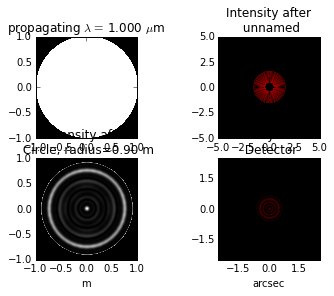

In [102]:
t0_fft = time.time()
annFPM_fft_psf, annFPM_fft_interm = fftcoron_annFPM_osys.calcPSF(1e-6, display_intermediates=True,\
                                                                 return_intermediates=True)
t1_fft = time.time()

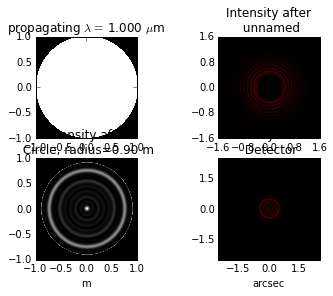

In [103]:
t0_mft = time.time()
annFPM_mft_psf, annFPM_mft_interm = matrixFTcoron_annFPM_osys.calcPSF(1e-6, display_intermediates=True,\
                                                                     return_intermediates=True)
t1_mft = time.time()

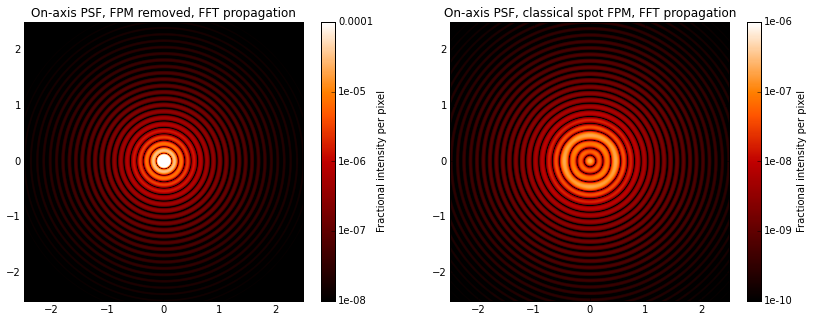

In [114]:
plt.figure(figsize=(14,5))
plt.subplot(121)
poppy.display_PSF(noFPM_fft_psf, vmax=1e-4, title='On-axis PSF, FPM removed, FFT propagation')
plt.subplot(122)
poppy.display_PSF(spotFPM_fft_psf, vmin=1e-10, vmax=1e-6, title='On-axis PSF, classical spot FPM, FFT propagation')

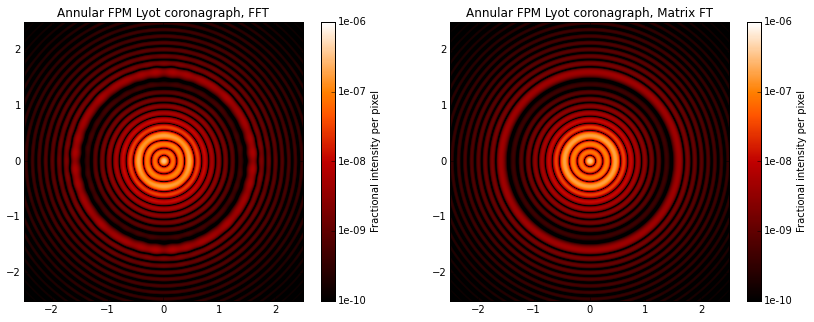

In [112]:
plt.figure(figsize=(14,5))
plt.subplot(121)
poppy.display_PSF(annFPM_fft_psf, vmin=1e-10, vmax=1e-6, title='Annular FPM Lyot coronagraph, FFT')
plt.subplot(122)
poppy.display_PSF(annFPM_mft_psf, vmin=1e-10, vmax=1e-6, title='Annular FPM Lyot coronagraph, Matrix FT')

In [126]:
lamoD_asec = 1e-6/(2*fftcoron_annFPM_osys.planes[0].radius) * 180/np.pi * 3600
print "System diffraction resolution element scale (lambda/D) in arcsec: %.3f" % lamoD_asec
print "Array width in first focal plane, FFT: %d" % annFPM_fft_interm[1].amplitude.shape[0]
print "Array width in first focal plane, MatrixFT: %d" % annFPM_mft_interm[1].amplitude.shape[0]
print "Array width in Lyot plane, FFT: %d" % annFPM_fft_interm[2].amplitude.shape[0]
print "Array width in Lyot plane, MatrixFT: %d" % annFPM_mft_interm[2].amplitude.shape[0]

System diffraction resolution element scale (lambda/D) in arcsec: 0.103
Array width in first focal plane, FFT: 4096
Array width in first focal plane, MatrixFT: 1638
Array width in Lyot plane, FFT: 4096
Array width in Lyot plane, MatrixFT: 1024


In [107]:
print "Elapsed time, FFT:  %.1f s" % (t1_fft-t0_fft)
print "Elapsed time, Matrix FT:  %.1f s" % (t1_mft-t0_mft)

Elapsed time, FFT:  30.8 s
Elapsed time, Matrix FT:  6.5 s
